## Import librairies

In [29]:
import sys
from pathlib import Path
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import os
import locale
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime

# Ajouter le dossier parent src au path
sys.path.append(os.path.abspath('..'))

%matplotlib inline


## CONSTANTES

In [30]:
EXTRACT_DATE = datetime(2025, 11, 1, 17, 2, 28)

PRICE_SEGMENTS = [
    {
        "label": "0 - 7.99",
        "value_min": 0,
        "value_max": 7.99,
    },
    {
        "label": "8 - 14.99",
        "value_min": 8,
        "value_max": 14.99,
    },
    {
        "label": "15 - 24.99",
        "value_min": 15,
        "value_max": 24.99,
    },
    {
        "label": "25 - 39.99",
        "value_min": 25,
        "value_max": 39.99,
    },
    {
        "label": "40+",
        "value_min": 40,
        "value_max": 150,
    },
]

PROMOS = [10,25,33,50,75]


In [31]:
# Fichier stocké temporairement sur un de mes S3
# url = "https://d3aok2axxchxf9.cloudfront.net/ia/games_data.csv"

url = os.path.join(Path.cwd().parent, "data/processed/games_data.csv")

# Charger les données CSV, Les colonnes Boolean sont au format Int64 (0,1,NaN)
df = pd.read_csv(url,dtype={
    'trophies_count': 'Int64',
    'local_multiplayer_max_players': 'Int64',
    'online_multiplayer_max_players': 'Int64',
    'difficulty': 'Int64',
    'download_size': 'Int64',
    'hours_main_story': 'Int64',
    'hours_completionist': 'Int64',
    'metacritic_critic_score': 'Int64',
    'metacritic_critic_userscore': 'Int64',
    'pegi_rating': 'Int64',
})


## EDA - Analyse exploratoire détaillée

- Les colonnes de prix sont en euros.

In [32]:
def column_summary(df:pd.DataFrame):
    summary = []
    for col in df.columns:
        col_type = df[col].dtype
        non_null = df[col].notna().sum()
        null_count = df[col].isna().sum()
        unique_count = df[col].nunique()

        summary.append({
            'Column': col,
            'Type': str(col_type),
            'Non-Null Count': non_null,
            'Null Count': null_count,
            'Unique Values': unique_count,
        })

    return pd.DataFrame(summary)

# Afficher le résumé des colonnes
print("=" * 80)
print("Résumé détaillé des colonnes:")
print("=" * 80)
column_summary_df = column_summary(df)
print(column_summary_df.to_string(index=False))
print("\n")

Résumé détaillé des colonnes:
                        Column    Type  Non-Null Count  Null Count  Unique Values
                     game_name  object            5382           0           5382
                      id_store  object            5382           0           5382
                short_url_name  object            5382           0           5382
                     publisher  object            5382           0           1083
                     developer  object            3920        1462           2709
                  release_date  object            5382           0           1347
         pssstore_stars_rating float64            5382           0            352
   pssstore_stars_rating_count   int64            5382           0           1583
       metacritic_critic_score   Int64            1268        4114             67
   metacritic_critic_userscore   Int64            1268        4114             10
                        genres  object            5360          22  

In [33]:
df.head()

,game_name,id_store,short_url_name,publisher,developer,release_date,pssstore_stars_rating,pssstore_stars_rating_count,metacritic_critic_score,metacritic_critic_userscore,...,hours_main_story,hours_completionist,pegi_rating,esrb_rating,rating_descriptions,voice_languages,subtitle_languages,base_price,lowest_price,price_history
0,"#Halloween, Super Puzzles Dream",EP8311-PPSA19174_00-0421646910657705,game-halloween-super-puzzles-dream-ps5,e-llusiontertainment,NaN,2023-10-30,1.57,14,<NA>,<NA>,...,<NA>,<NA>,7,Everyone,Fear/Horror,NaN,NaN,4.99,1.49,"[{""x"": ""2023-11-02"", ""y"": 4.99}, {""x"": ""2023-1..."
1,#SinucaAttack,EP2005-PPSA06055_00-SINUCA0000000000,game-sinucaattack-ps5,eastasiasoft,NaN,2022-05-19,3.26,72,<NA>,<NA>,...,0,0,3,Everyone,Fantasy Violence,NaN,NaN,4.99,1.49,"[{""x"": ""2022-05-21"", ""y"": 4.99}, {""x"": ""2022-1..."
2,"#Wish travel, super puzzle dreams",EP8311-PPSA16513_00-0233078860249892,game-wish-travel-super-puzzle-dreams-ps5,e-llusiontertainment,NaN,2023-05-31,1.55,11,<NA>,<NA>,...,<NA>,<NA>,3,Everyone,NaN,NaN,NaN,4.99,1.49,"[{""x"": ""2023-06-19"", ""y"": 4.99}, {""x"": ""2023-0..."
3,"#WomenUp, Super Puzzles Dream",EP8311-PPSA13840_00-0277389480637871,game-womenup-super-puzzles-dream-ps5,e-llusiontertainment,NaN,2023-01-26,1.44,18,<NA>,<NA>,...,<NA>,<NA>,3,Everyone,NaN,NaN,NaN,4.99,1.49,"[{""x"": ""2023-05-21"", ""y"": 4.99}, {""x"": ""2023-0..."
4,"#Xmas, Super Puzzles Dream",EP8311-PPSA12662_00-0212989199890961,game-xmas-super-puzzles-dream-ps5,e-llusiontertainment,NaN,2022-12-22,1.17,23,<NA>,<NA>,...,<NA>,<NA>,3,Everyone,NaN,NaN,NaN,4.99,1.49,"[{""x"": ""2023-01-23"", ""y"": 4.99}, {""x"": ""2023-0..."


In [34]:
df.describe()

,pssstore_stars_rating,pssstore_stars_rating_count,metacritic_critic_score,metacritic_critic_userscore,is_ps4,is_ps5,is_indie,is_dlc,is_vr,is_opti_ps5_pro,...,has_online_multiplayer,online_multiplayer_max_players,is_online_only,difficulty,download_size,hours_main_story,hours_completionist,pegi_rating,base_price,lowest_price
count,5382.000000,5.382000e+03,1268.0,1268.0,5382.000000,5382.0,5382.000000,5382.0,5382.000000,5382.000000,...,5382.000000,5382.0,5382.000000,2427.0,2528.0,3353.0,2905.0,4562.0,5382.000000,5382.000000
mean,3.862824,3.501787e+03,57.87224,59.124606,0.447046,1.0,0.423820,0.0,0.050353,0.028428,...,0.143627,1.196024,0.020810,3.416976,6334336842.530854,10.283925,11.456454,8.772907,18.526524,9.020821
std,0.691182,3.622325e+04,30.002306,20.191043,0.497234,0.0,0.494208,0.0,0.218693,0.166208,...,0.350744,6.523387,0.142761,2.614881,15086547791.580881,28.962312,44.02705,5.475559,16.451834,9.519553
min,0.000000,0.000000e+00,3.0,0.0,0.000000,1.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,1.0,327679.0,0.0,0.0,3.0,1.190000,0.540000
25%,3.520000,3.100000e+01,45.75,50.0,0.000000,1.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,2.0,225771520.0,1.0,1.0,3.0,5.990000,2.490000
50%,4.000000,8.800000e+01,71.0,60.0,0.000000,1.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,3.0,886177792.0,5.0,5.0,7.0,14.990000,5.990000
75%,4.360000,4.610000e+02,79.0,70.0,1.000000,1.0,1.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,4.0,4170399744.0,11.0,12.0,12.0,24.990000,11.990000
max,5.000000,1.825682e+06,96.0,90.0,1.000000,1.0,1.000000,0.0,1.000000,1.000000,...,1.000000,99.0,1.000000,11.0,147972947968.0,1000.0,1500.0,18.0,94.990000,79.990000


In [35]:
def draw_binary_circular_plots(data: list, name: str, axe: plt.Axes):
    colors = sns.color_palette("crest")
    values = [item["value"] for item in data]
    labels = [item["label"] for item in data]

    wedges, texts, autotexts = axe.pie(
        values,
        labels=labels,
        colors=colors,
        autopct="%1.1f%%",
        startangle=90,
        shadow=False,
    )

    for autotext in autotexts:
        autotext.set_color("white")
        autotext.set_fontweight("bold")

    axe.set_title(f"{name}", fontweight="bold", pad=20)
    
    
def layout_plots(n_cols: int):
    # Calculer le nombre de lignes nécessaires
    actual_rows = (n_cols + 2) // 3  # 3 colonnes par ligne

    # Limiter à 3 colonnes maximum
    actual_cols = min(n_cols, 3)

    # Créer la figure avec plus d'espace vertical
    fig, axes = plt.subplots(
        actual_rows, 
        actual_cols, 
        figsize=(14, 5 * actual_rows),  # Hauteur dynamique selon le nombre de lignes
        gridspec_kw={'hspace': 0.5, 'wspace': 0.3}  # ← Espace entre les lignes/colonnes
    )

    # Normaliser axes pour toujours retourner un tableau 1D itérable
    if n_cols == 1:
        axes = [axes]
    elif actual_rows == 1 and actual_cols == 1:
        axes = [axes]
    elif actual_rows == 1:
        axes = list(axes)
    else:
        axes = list(axes.flatten())

    return fig, axes

def generate_multi_str_col_top_proportion_data(
    df: pd.DataFrame, col_name: str, top_count: int
):

    # Séparer les genres et exploser
    genres_exploded = df[col_name].str.split(",").explode()
    genres_exploded = genres_exploded.str.strip()
    genre_counts = genres_exploded.value_counts()

    # Garder le top 6 et regrouper le reste dans "Autres"
    top_val = genre_counts.head(top_count)
    autres = genre_counts.iloc[top_count:].sum()

    # Créer les données finales
    if autres > 0:
        final_counts = pd.concat([top_val, pd.Series({"Autres": autres})])
    else:
        final_counts = top_val

    result = []
    for label, value in final_counts.items():
        result.append(
            {
                "label": label,
                "value": value,
            }
        )

    return result

## Analyse dates de sorties

ANALYSE DES DATES DE SORTIE

📅 PÉRIODE COUVERTE:
  Date la plus ancienne : 2020-11-11
  Date la plus récente : 2025-10-23
  Période totale : 1807 jours (5.0 ans)
  Dates manquantes : 0 / 5382 (0.0%)

⏳ ANCIENNETÉ DES JEUX:
  Ancienneté moyenne : 703 jours (1.9 ans)
  Ancienneté médiane : 628 jours (1.7 ans)
  Jeu le plus ancien : 1831 jours (5.0 ans)
  Jeu le plus récent : 24 jours (0.1 ans)

🆕 SORTIES RÉCENTES:
  Derniers 30 jours : 16 jeux (0.3%)
  Derniers 90 jours : 229 jeux (4.3%)
  Derniers 6 mois : 622 jeux (11.6%)
  Dernière année : 1462 jeux (27.2%)

👴 JEUX ANCIENS:
  Plus de 2 ans : 2358 jeux (43.8%)
  Plus de 5 ans : 18 jeux (0.3%)
  Plus de 10 ans : 0 jeux (0.0%)


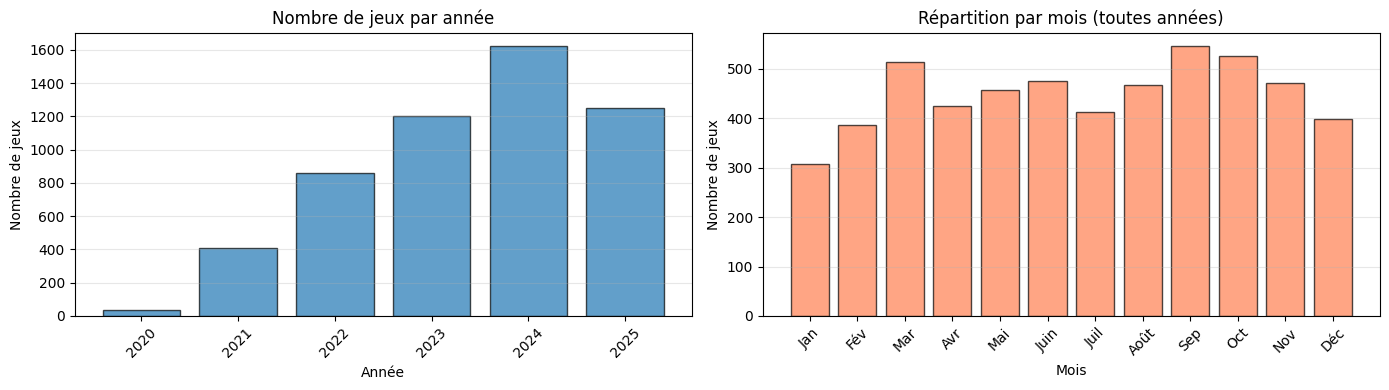

In [37]:
def analyze_release_dates(df):
    print("=" * 80)
    print("ANALYSE DES DATES DE SORTIE")
    print("=" * 80)
    
    # Convertir en datetime si nécessaire
    df['release_date_dt'] = pd.to_datetime(df['release_date'], errors='coerce')
    today = datetime.now()
    
    # 1. STATISTIQUES GÉNÉRALES
    print("\n📅 PÉRIODE COUVERTE:")
    
    oldest_release = df['release_date_dt'].min()
    newest_release = df['release_date_dt'].max()
    missing_dates = df['release_date_dt'].isna().sum()
    
    print(f"  Date la plus ancienne : {oldest_release.strftime('%Y-%m-%d') if pd.notna(oldest_release) else 'N/A'}")
    print(f"  Date la plus récente : {newest_release.strftime('%Y-%m-%d') if pd.notna(newest_release) else 'N/A'}")
    
    if pd.notna(oldest_release) and pd.notna(newest_release):
        print(f"  Période totale : {(newest_release - oldest_release).days} jours ({(newest_release - oldest_release).days/365:.1f} ans)")
        
    print(f"  Dates manquantes : {missing_dates} / {len(df)} ({missing_dates/len(df)*100:.1f}%)")
    
    # 2. ANCIENNETÉ DES JEUX
    print("\n⏳ ANCIENNETÉ DES JEUX:")
    
    df['days_since_release'] = (today - df['release_date_dt']).dt.days
    df['years_since_release'] = df['days_since_release'] / 365.25
    
    print(f"  Ancienneté moyenne : {df['days_since_release'].mean():.0f} jours ({df['years_since_release'].mean():.1f} ans)")
    print(f"  Ancienneté médiane : {df['days_since_release'].median():.0f} jours ({df['years_since_release'].median():.1f} ans)")
    print(f"  Jeu le plus ancien : {df['days_since_release'].max():.0f} jours ({df['years_since_release'].max():.1f} ans)")
    print(f"  Jeu le plus récent : {df['days_since_release'].min():.0f} jours ({df['years_since_release'].min():.1f} ans)")

    # 6. SORTIES RÉCENTES
    print("\n🆕 SORTIES RÉCENTES:")
    
    last_30_days = (df['days_since_release'] <= 30).sum()
    last_90_days = (df['days_since_release'] <= 90).sum()
    last_180_days = (df['days_since_release'] <= 180).sum()
    last_365_days = (df['days_since_release'] <= 365).sum()
    
    print(f"  Derniers 30 jours : {last_30_days} jeux ({last_30_days/len(df)*100:.1f}%)")
    print(f"  Derniers 90 jours : {last_90_days} jeux ({last_90_days/len(df)*100:.1f}%)")
    print(f"  Derniers 6 mois : {last_180_days} jeux ({last_180_days/len(df)*100:.1f}%)")
    print(f"  Dernière année : {last_365_days} jeux ({last_365_days/len(df)*100:.1f}%)")
    
    # 7. JEUX ANCIENS
    print("\n👴 JEUX ANCIENS:")
    
    older_2_years = (df['years_since_release'] >= 2).sum()
    older_5_years = (df['years_since_release'] >= 5).sum()
    older_10_years = (df['years_since_release'] >= 10).sum()
    
    print(f"  Plus de 2 ans : {older_2_years} jeux ({older_2_years/len(df)*100:.1f}%)")
    print(f"  Plus de 5 ans : {older_5_years} jeux ({older_5_years/len(df)*100:.1f}%)")
    print(f"  Plus de 10 ans : {older_10_years} jeux ({older_10_years/len(df)*100:.1f}%)")
    
    df['release_year'] = df['release_date_dt'].dt.year
    df['release_month'] = df['release_date_dt'].dt.month
    
    return df

# Lancer l'analyse
df = analyze_release_dates(df)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14, 4))
ax1: plt.Axes
ax2: plt.Axes

# Distribution des années
year_counts = df['release_year'].value_counts().sort_index()

ax1.bar(year_counts.index, year_counts.values, edgecolor='black', alpha=0.7)
ax1.set_xlabel('Année')
ax1.set_ylabel('Nombre de jeux')
ax1.set_title('Nombre de jeux par année')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(alpha=0.3, axis='y')

# Distribution par mois (toutes années confondues)
month_counts = df['release_month'].value_counts().sort_index()
month_names = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc']
ax2.bar(range(1, 13), [month_counts.get(i, 0) for i in range(1, 13)], 
               edgecolor='black', alpha=0.7, color='coral')
ax2.set_xlabel('Mois')
ax2.set_ylabel('Nombre de jeux')
ax2.set_title('Répartition par mois (toutes années)')
ax2.set_xticks(range(1, 13))
ax2.set_xticklabels(month_names, rotation=45)
ax2.grid(alpha=0.3, axis='y')


plt.tight_layout()
plt.show()

## Analyse des données catégorielles

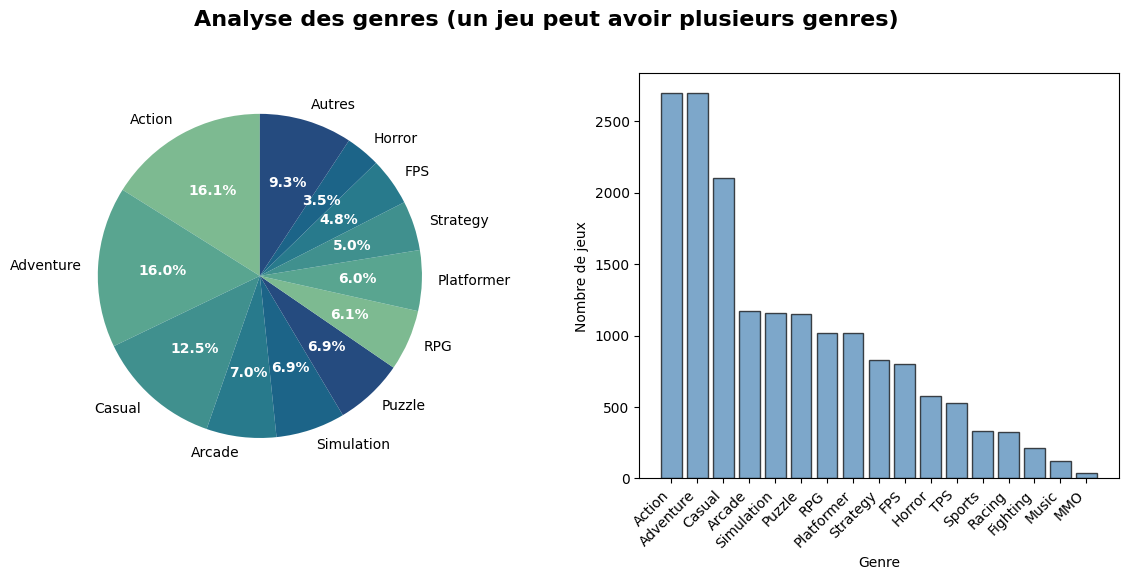

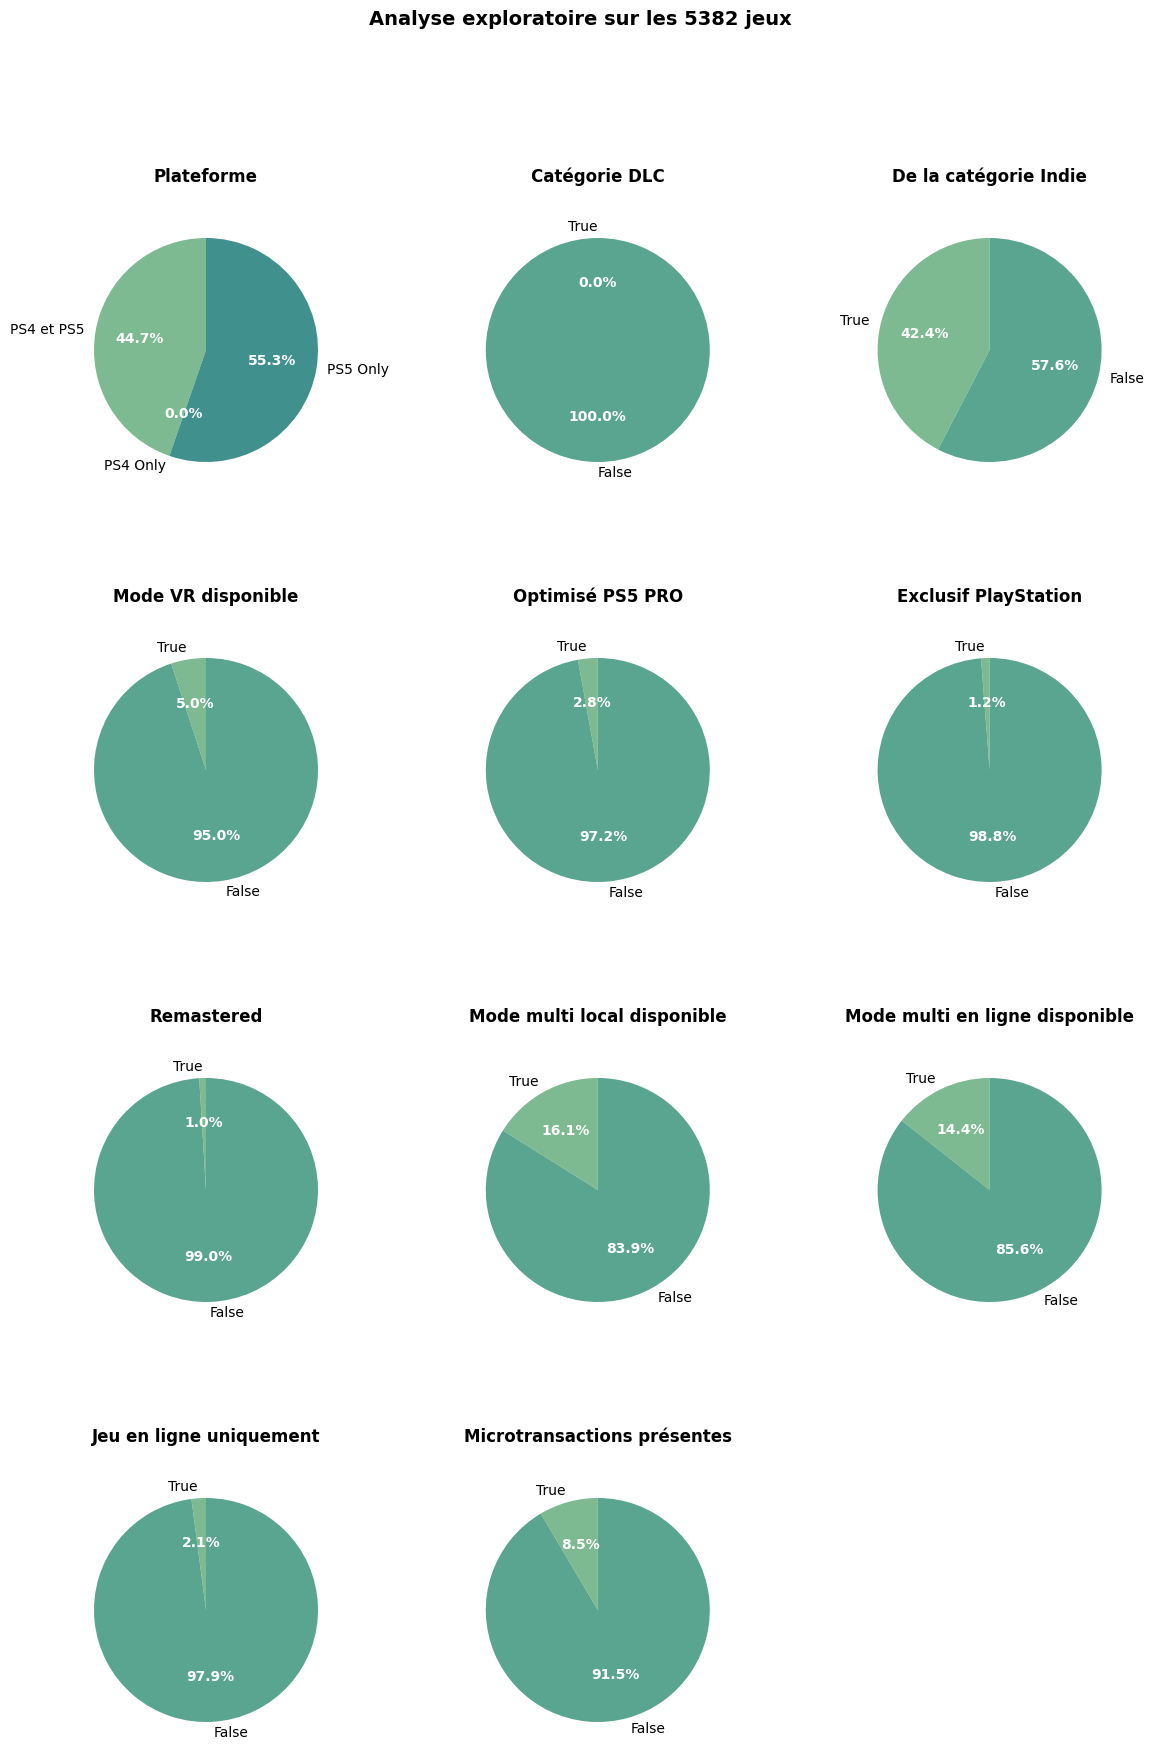

In [38]:
def generate_platform_proportion_data(df: pd.DataFrame):
    result = [
        {
            "label": "PS4 et PS5",
            "value": ((df["is_ps4"] == 1) & (df["is_ps5"] == 1)).sum(),
        },
        {
            "label": "PS4 Only",
            "value": ((df["is_ps4"] == 1) & (df["is_ps5"] == 0)).sum(),
        },
        {
            "label": "PS5 Only",
            "value": ((df["is_ps4"] == 0) & (df["is_ps5"] == 1)).sum(),
        },
    ]

    return result

def generate_binary_cols_proportion_data(df: pd.DataFrame, column_name: str):
    binary_cols = [col for col in df.columns if col == column_name]

    if len(binary_cols) == 0:
        return None

    result = [
        {
            "label": "True",
            "value": (
                (df[binary_cols[0]] == 1).sum() / len(df) * 100 if len(df) > 0 else 0
            ),
        },
        {
            "label": "False",
            "value": (
                (df[binary_cols[0]] == 0).sum() / len(df) * 100 if len(df) > 0 else 0
            ),
        },
    ]

    return result


def generate_proportion_analyse_plot(df: pd.DataFrame):
    data_plateform = generate_platform_proportion_data(df)
    
    list_cols_true_false = [
        {"col": "is_dlc", "title": "Catégorie DLC"},
        {"col": "is_indie", "title": "De la catégorie Indie"},
        {"col": "is_vr", "title": "Mode VR disponible"},
        {"col": "is_opti_ps5_pro", "title": "Optimisé PS5 PRO"},
        {"col": "is_ps_exclusive", "title": "Exclusif PlayStation"},
        {"col": "is_remaster", "title": "Remastered"},
        {"col": "has_local_multiplayer", "title": "Mode multi local disponible"},
        {"col": "has_online_multiplayer", "title": "Mode multi en ligne disponible"},
        {"col": "is_online_only", "title": "Jeu en ligne uniquement"},
        {"col": "has_microtransactions", "title": "Microtransactions présentes"},
    ]

    fig, axes = layout_plots(11)

    draw_binary_circular_plots(data_plateform, "Plateforme", axes[0])

    cpt = 1
    for col_plt in list_cols_true_false:
        data_plt = generate_binary_cols_proportion_data(df, col_plt["col"])
        if data_plt is not None:
            draw_binary_circular_plots(data_plt, col_plt["title"], axes[cpt])
            cpt += 1

    for j in range(cpt, len(axes)):
        axes[j].axis("off")
        
    fig.suptitle(
        f"Analyse exploratoire sur les {len(df)} jeux",
        fontsize=14,
        fontweight="bold",
    )
    plt.show()
    
def histogram_genres_count(df: pd.DataFrame, axe: plt.Axes):

    # Séparer les genres et exploser
    genres_exploded = df["genres"].str.split(",").explode()
    genres_exploded = genres_exploded.str.strip()
    genre_counts = genres_exploded.value_counts()

    axe.bar(
        range(len(genre_counts)),
        genre_counts.values,
        color="steelblue",
        edgecolor="black",
        alpha=0.7,
    )

    axe.set_xticks(range(len(genre_counts)))
    axe.set_xticklabels(genre_counts.index, rotation=45, ha="right")

    axe.set_xlabel("Genre")
    axe.set_ylabel("Nombre de jeux")


def genres_distribution(df: pd.DataFrame, save_file=False):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1: plt.Axes
    ax2: plt.Axes

    data = generate_multi_str_col_top_proportion_data(df, "genres", top_count=11)
    draw_binary_circular_plots(
        data,
        "",
        ax1,
    )

    histogram_genres_count(df, ax2)

    fig.suptitle(
        "Analyse des genres (un jeu peut avoir plusieurs genres)",
        fontsize=16,
        fontweight="bold",
    )

    plt.tight_layout(pad=2.0)
    plt.show()

genres_distribution(df)
    
generate_proportion_analyse_plot(df)

## Analyse des prix de base

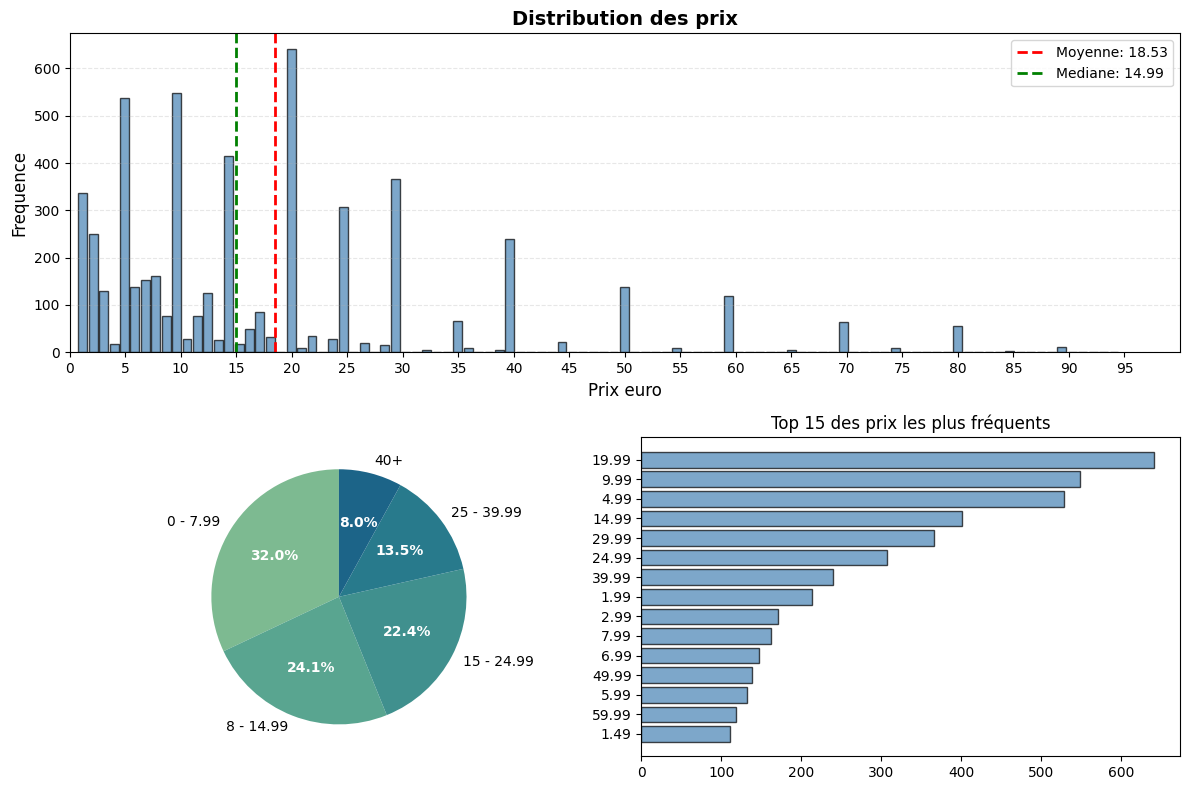

In [39]:
def generate_base_price_proportion_data(df: pd.DataFrame):
    result = []
    for seg in PRICE_SEGMENTS:
        result.append(
            {
                "label": seg["label"],
                "value": (
                    (df["base_price"] >= seg["value_min"])
                    & (df["base_price"] <= seg["value_max"])
                ).sum(),
            }
        )

    return result

def histogram_base_price_frequence(df: pd.DataFrame, axe: plt.Axes):

    counts, bin_edges = np.histogram(df["base_price"], bins=100)
    
    axe.bar(
        bin_edges[:-1],  # Utiliser les bords gauches (sans le dernier)
        counts,
        color="steelblue",
        edgecolor="black",
        alpha=0.7,
        align="center",
    )

    axe.set_xlabel("Prix euro", fontsize=12)
    axe.set_ylabel("Frequence", fontsize=12)
    axe.set_title("Distribution des prix", fontsize=14, fontweight="bold")
    axe.grid(axis="y", alpha=0.3, linestyle="--")
    axe.set_xticks(range(0, 100, 5))
    axe.set_xlim(0, 100)

    # Afficher des statistiques
    mean_price = df["base_price"].mean()
    median_price = df["base_price"].median()

    axe.axvline(
        mean_price,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Moyenne: {mean_price:.2f}",
    )
    axe.axvline(
        median_price,
        color="green",
        linestyle="--",
        linewidth=2,
        label=f"Mediane: {median_price:.2f}",
    )
    axe.legend()


def histogram_base_price_unique_count(df: pd.DataFrame, axe: plt.Axes):
    price_counts = df["base_price"].value_counts().sort_index()
    axe.barh(price_counts.index, price_counts.values)
    axe.set_title("Frequence des prix uniques", fontsize=14)
    axe.set_xlabel("Frequence", fontsize=12)
    axe.set_ylabel("Prix", fontsize=12)
    axe.grid(axis="x", alpha=0.3)

def histogram_base_price_unique_count_top(df: pd.DataFrame, axe: plt.Axes):
    # Compter les occurrences et prendre les plus fréquents
    top = df["base_price"].value_counts().head(15).sort_values()

    axe.barh(  # barh au lieu de bar pour horizontal
        range(len(top)),  # Positions sur l'axe y
        top.values,  # Fréquences sur l'axe x
        color="steelblue",
        edgecolor="black",
        alpha=0.7,
    )

    # Configurer les étiquettes de l'axe y avec les valeurs de base_price
    axe.set_yticks(range(len(top)))
    axe.set_yticklabels(top.index)
    axe.set_title("Top 15 des prix les plus fréquents")


def prices_distribution(df: pd.DataFrame, save_file=False):

    fig = plt.figure(figsize=(12, 8))

    # Première ligne : 1 graphique qui prend toute la largeur
    ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)

    # Deuxième ligne : 2 graphiques
    ax2 = plt.subplot2grid((2, 2), (1, 0))
    ax3 = plt.subplot2grid((2, 2), (1, 1))

    histogram_base_price_frequence(df, ax1)

    data_price = generate_base_price_proportion_data(df)
    draw_binary_circular_plots(data_price, "", ax2)

    histogram_base_price_unique_count_top(df, ax3)

    plt.tight_layout()
    plt.show()

prices_distribution(df)

## Analyse historique baisse de prix

In [40]:
# Convertir la colonne price_history de string vers list
df['price_history'] = df['price_history'].apply(
    lambda x: json.loads(x) if isinstance(x, str) else x
)

def get_oldest_date(price_history):
    if not price_history or len(price_history) == 0:
        return None
    try:
        dates = [datetime.strptime(entry['x'], "%Y-%m-%d") for entry in price_history]
        return min(dates) if dates else None
    except:
        return None

def get_newest_date(price_history):
    if not price_history or len(price_history) == 0:
        return None
    try:
        dates = [datetime.strptime(entry['x'], "%Y-%m-%d") for entry in price_history]
        return max(dates) if dates else None
    except:
        return None
    
    
def count_price_drops(price_history):
    """Compte le nombre de fois où le prix baisse"""
    if not price_history or len(price_history) < 2:
        return 0
    
    try:
        # Trier par date
        sorted_history = sorted(price_history, key=lambda x: x['x'])
        prices = [entry['y'] for entry in sorted_history if entry['y'] >= 0.1]
        
        if len(prices) < 2:
            return 0
        
        # Compter les baisses
        drops = 0
        for i in range(1, len(prices)):
            if prices[i] < prices[i-1]:
                drops += 1
        
        return drops
    except:
        return 0
    
def get_price_range(price_history):
    """Calcule la différence entre prix max et min"""
    if not price_history or len(price_history) == 0:
        return None
    try:
        prices = [entry['y'] for entry in price_history if entry['y'] >= 0.1]
        if not prices:
            return None
        return max(prices) - min(prices)
    except:
        return None

def get_max_discount_percent(price_history, base_price):
    """Calcule la réduction maximale en %"""
    if not price_history or len(price_history) == 0 or not base_price or base_price <= 0:
        return None
    try:
        prices = [entry['y'] for entry in price_history if entry['y'] >= 0.1]
        if not prices:
            return None
        min_price = min(prices)
        return ((base_price - min_price) / base_price) * 100
    except:
        return None
    
def get_avg_days_between_updates(price_history):
    """Calcule le nombre moyen de jours entre deux entrées"""
    if not price_history or len(price_history) < 2:
        return None
    try:
        dates = sorted([datetime.strptime(entry['x'], "%Y-%m-%d") for entry in price_history])
        if len(dates) < 2:
            return None
        
        intervals = [(dates[i+1] - dates[i]).days for i in range(len(dates)-1)]
        return sum(intervals) / len(intervals) if intervals else None
    except:
        return None
    
def has_valid_data(price_history):
    """Vérifie si l'historique contient des données valides"""
    if not price_history or len(price_history) == 0:
        return False
    try:
        for entry in price_history:
            if 'x' not in entry or 'y' not in entry:
                return False
            if entry['y'] < 0:
                return False
        return True
    except:
        return False
    
def has_zero_prices(price_history):
    if not price_history:
        return False
    return any(entry['y'] == 0 for entry in price_history)

def has_negative_prices(price_history):
    if not price_history:
        return False
    return any(entry['y'] < 0 for entry in price_history)

def analyze_price_history(df):
    """Analyse complète de l'historique des prix"""
    
    print("=" * 80)
    print("ANALYSE DE L'HISTORIQUE DES PRIX (price_history)")
    print("=" * 80)
    
    # 1. DATE LA PLUS ANCIENNE
    print("\n📅 DATES D'ENREGISTREMENT:")
    
    df['oldest_price_date'] = df['price_history'].apply(get_oldest_date)
    df['newest_price_date'] = df['price_history'].apply(get_newest_date)
    
    oldest_global = df['oldest_price_date'].min()
    newest_global = df['newest_price_date'].max()
    
    print(f"  Date la plus ancienne : {oldest_global}")
    print(f"  Date la plus récente : {newest_global}")
    if oldest_global and newest_global:
        print(f"  Période de collecte : {(newest_global - oldest_global).days} jours")
    
    # 2. NOMBRE D'ENTRÉES PAR JEU
    print("\n📊 NOMBRE D'ENTRÉES PRIX PAR JEU:")
    
    df['price_history_count'] = df['price_history'].apply(
        lambda x: len(x) if isinstance(x, list) else 0
    )
    
    print(f"  Moyenne : {df['price_history_count'].mean():.1f} entrées")
    print(f"  Médiane : {df['price_history_count'].median():.0f} entrées")
    print(f"  Min : {df['price_history_count'].min()} entrées")
    print(f"  Max : {df['price_history_count'].max()} entrées")
    print(f"  Jeux sans historique : {(df['price_history_count'] == 0).sum()}")
    
    # 3. NOMBRE DE BAISSES DE PRIX
    print("\n💰 NOMBRE DE BAISSES DE PRIX PAR JEU:")
    
    df['price_drops_count'] = df['price_history'].apply(count_price_drops)
    
    print(f"  Moyenne : {df['price_drops_count'].mean():.1f} baisses")
    print(f"  Médiane : {df['price_drops_count'].median():.0f} baisses")
    print(f"  Max : {df['price_drops_count'].max()} baisses")
    print(f"  Jeux sans baisse : {(df['price_drops_count'] == 0).sum()} ({(df['price_drops_count'] == 0).sum()/len(df)*100:.1f}%)")
    print(f"  Jeux avec 1+ baisse : {(df['price_drops_count'] > 0).sum()} ({(df['price_drops_count'] > 0).sum()/len(df)*100:.1f}%)")
    
    # 4. AMPLITUDE DES VARIATIONS DE PRIX
    print("\n📈 AMPLITUDE DES VARIATIONS:")
    
    df['price_range'] = df['price_history'].apply(get_price_range)
    df['max_discount_percent'] = df.apply(
        lambda row: get_max_discount_percent(row['price_history'], row['base_price']),
        axis=1
    )
    
    print(f"  Amplitude moyenne : {df['price_range'].mean():.2f}€")
    print(f"  Amplitude médiane : {df['price_range'].median():.2f}€")
    print(f"  Réduction max moyenne : {df['max_discount_percent'].mean():.1f}%")
    print(f"  Réduction max médiane : {df['max_discount_percent'].median():.1f}%")
    
    # 5. FRÉQUENCE DE MISE À JOUR
    print("\n⏱️ FRÉQUENCE DE MISE À JOUR:")
    
    df['avg_days_between_updates'] = df['price_history'].apply(get_avg_days_between_updates)
    
    print(f"  Intervalle moyen : {df['avg_days_between_updates'].mean():.1f} jours")
    print(f"  Intervalle médian : {df['avg_days_between_updates'].median():.1f} jours")
    
    # 6. QUALITÉ DES DONNÉES
    print("\n✅ QUALITÉ DES DONNÉES:")
    
    df['has_valid_price_history'] = df['price_history'].apply(has_valid_data)
    
    valid_count = df['has_valid_price_history'].sum()
    print(f"  Jeux avec données valides : {valid_count} / {len(df)} ({valid_count/len(df)*100:.1f}%)")
    print(f"  Jeux avec données manquantes/invalides : {len(df) - valid_count} ({(len(df)-valid_count)/len(df)*100:.1f}%)")
    
    # 7. PRIX SUSPECTS
    print("\n⚠️ ANOMALIES DÉTECTÉES:")
    
    zero_prices = df['price_history'].apply(has_zero_prices).sum()
    negative_prices = df['price_history'].apply(has_negative_prices).sum()
    
    print(f"  Jeux avec prix à 0€ : {zero_prices}")
    print(f"  Jeux avec prix négatifs : {negative_prices}")
    
    return df

# Lancer l'analyse
df = analyze_price_history(df)

ANALYSE DE L'HISTORIQUE DES PRIX (price_history)

📅 DATES D'ENREGISTREMENT:
  Date la plus ancienne : 2020-11-11 00:00:00
  Date la plus récente : 2025-10-29 00:00:00
  Période de collecte : 1813 jours

📊 NOMBRE D'ENTRÉES PRIX PAR JEU:
  Moyenne : 28.8 entrées
  Médiane : 26 entrées
  Min : 1 entrées
  Max : 129 entrées
  Jeux sans historique : 0

💰 NOMBRE DE BAISSES DE PRIX PAR JEU:
  Moyenne : 8.9 baisses
  Médiane : 7 baisses
  Max : 62 baisses
  Jeux sans baisse : 579 (10.8%)
  Jeux avec 1+ baisse : 4803 (89.2%)

📈 AMPLITUDE DES VARIATIONS:
  Amplitude moyenne : 10.58€
  Amplitude médiane : 6.00€
  Réduction max moyenne : 47.8%
  Réduction max médiane : 50.0%

⏱️ FRÉQUENCE DE MISE À JOUR:
  Intervalle moyen : 36.7 jours
  Intervalle médian : 24.6 jours

✅ QUALITÉ DES DONNÉES:
  Jeux avec données valides : 5382 / 5382 (100.0%)
  Jeux avec données manquantes/invalides : 0 (0.0%)

⚠️ ANOMALIES DÉTECTÉES:
  Jeux avec prix à 0€ : 0
  Jeux avec prix négatifs : 0


## Analyse nombre de jours avant promotion

       days_to_10_percent_discount  days_to_25_percent_discount  \
count                  4778.000000                  4509.000000   
mean                    111.046463                   139.444666   
std                     114.792521                   130.566226   
min                       0.000000                     0.000000   
25%                      48.000000                    57.000000   
50%                      76.000000                    98.000000   
75%                     128.000000                   175.000000   
max                    1292.000000                  1292.000000   

       days_to_33_percent_discount  days_to_50_percent_discount  \
count                  3714.000000                  3091.000000   
mean                    205.792138                   290.918149   
std                     159.093618                   207.714124   
min                       0.000000                     0.000000   
25%                      97.000000                   142.0000

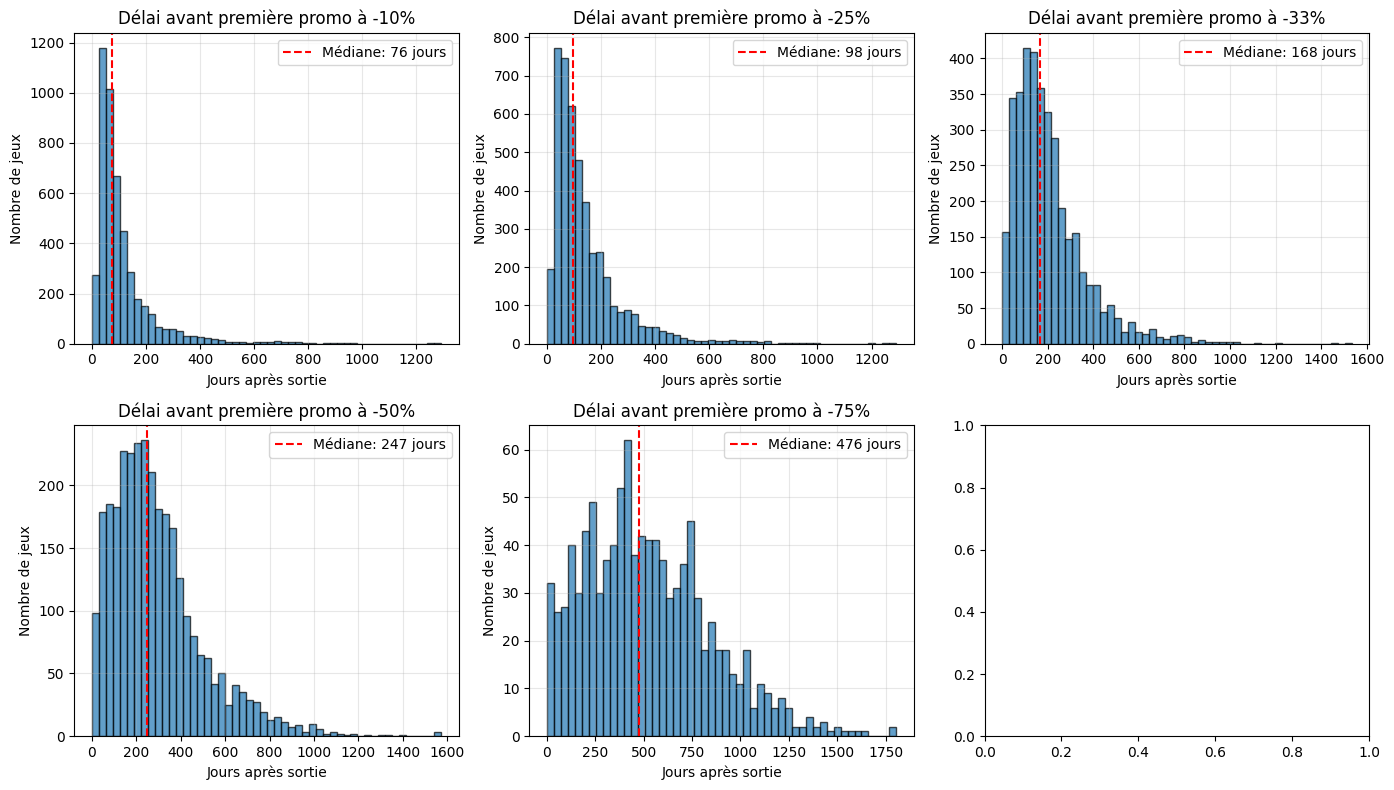


RÉSUMÉ DES PROMOTIONS
Réduction  Jeux concernés Pourcentage  Médiane (jours)  Moyenne (jours)  Min (jours)  Max (jours)
     -10%            4778       88.8%             76.0       111.046463          0.0       1292.0
     -25%            4509       83.8%             98.0       139.444666          0.0       1292.0
     -33%            3714       69.0%            168.0       205.792138          0.0       1533.0
     -50%            3091       57.4%            247.0       290.918149          0.0       1574.0
     -75%            1025       19.0%            476.0       519.724878          1.0       1806.0


In [41]:
def days_until_first_discount(
    sales_history, base_price, release_date, discount_threshold=0
):
    if release_date is None:
        return None

    if len(sales_history) == 0:
        return None

    if not isinstance(base_price, (int, float)):
        return None

    # Convertir release_date en datetime si c'est une string
    if isinstance(release_date, str):
        release_date = datetime.strptime(release_date, "%Y-%m-%d")

    # Calculer le prix cible selon le seuil de réduction
    target_price = base_price * (1 - discount_threshold / 100)

    # Parcourir l'historique pour trouver la première baisse atteignant le seuil
    for entry in sales_history:
        price = entry["y"]
        date_str = entry["x"]
        date = datetime.strptime(date_str, "%Y-%m-%d")

        # Ignorer les prix négatifs
        if price < 0.1:
            continue

        # Vérifier si la réduction atteint le seuil et après la date de sortie
        if price <= target_price and date >= release_date:
            days_diff = (date - release_date).days
            return days_diff

    # Aucune baisse au seuil voulu trouvée
    return None

for promo in PROMOS:
    col_name = f'days_to_{promo}_percent_discount'
    df[col_name] = df.apply(
        lambda row: days_until_first_discount(
            row['price_history'], 
            row['base_price'], 
            row['release_date'], 
            promo
        ),
        axis=1
    )
    
# Calculer l'ancienneté de chaque jeu
df['release_date_dt'] = pd.to_datetime(df['release_date'])

df['days_since_release'] = (EXTRACT_DATE - df['release_date_dt']).dt.days

# Afficher un résumé des nouvelles colonnes
new_cols = [f'days_to_{p}_percent_discount' for p in PROMOS]
new_cols += ['days_since_release']

print(df[new_cols].describe())

# Créer un graphique pour chaque seuil de promo
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for idx, promo in enumerate(PROMOS):
    col = f'days_to_{promo}_percent_discount'
    data = df[col].dropna()
    
    ax = axes[idx]
    
    ax : plt.Axes
    
    ax.hist(data, bins=50, edgecolor='black', alpha=0.7)
    ax.axvline(data.median(), color='red', linestyle='--', 
                      label=f'Médiane: {data.median():.0f} jours')
    ax.set_xlabel('Jours après sortie')
    ax.set_ylabel('Nombre de jeux')
    ax.set_title(f'Délai avant première promo à -{promo}%')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


summary_data = []
for promo in PROMOS:
    col = f'days_to_{promo}_percent_discount'
    summary_data.append({
        'Réduction': f'-{promo}%',
        'Jeux concernés': df[col].notna().sum(),
        'Pourcentage': f"{(df[col].notna().sum() / len(df)) * 100:.1f}%",
        'Médiane (jours)': df[col].median(),
        'Moyenne (jours)': df[col].mean(),
        'Min (jours)': df[col].min(),
        'Max (jours)': df[col].max()
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("RÉSUMÉ DES PROMOTIONS")
print("="*80)
print(summary_df.to_string(index=False))



## Analyse des jeux sans promotion

In [42]:
# Jeux n'ayant JAMAIS eu de réduction (même pas 10%)
no_discount_ever = df[df['days_to_10_percent_discount'].isna()].copy()

print("=" * 80)
print("JEUX SANS RÉDUCTION (jamais ou moin de 10%)")
print("=" * 80)
print(f"\n📊 Total de jeux : {len(no_discount_ever)} / {len(df)} ({len(no_discount_ever)/len(df)*100:.1f}%)")
print("\n💰 PRIX:")
print(f"  Prix moyen : {no_discount_ever['base_price'].mean():.2f}€")
print(f"  Prix médian : {no_discount_ever['base_price'].median():.2f}€")
print(f"  Prix min : {no_discount_ever['base_price'].min():.2f}€")
print(f"  Prix max : {no_discount_ever['base_price'].max():.2f}€")

# Comparaison avec les jeux ayant eu des réductions
with_discount = df[df['days_to_10_percent_discount'].notna()]
print(f"\n  💡 Prix moyen (avec réduction > 10%) : {with_discount['base_price'].mean():.2f}€")
print(f"  💡 Différence : {no_discount_ever['base_price'].mean() - with_discount['base_price'].mean():.2f}€")


# Tester plusieurs seuils
thresholds = [30, 60, 90, 180, 365]

print("\n" + "=" * 80)
print("ANALYSE PAR SEUIL DE RÉCENCE")
print("=" * 80)

for threshold in thresholds:
    too_recent = df[df['days_since_release'] < threshold]
    too_recent_no_discount = df[
        (df['days_since_release'] < threshold) & 
        (df['days_to_10_percent_discount'].isna())
    ]
    
    print(f"\n📅 Moins de {threshold} jours ({threshold//30} mois):")
    print(f"   Jeux récents : {len(too_recent)}")
    print(f"   Sans réduction : {len(too_recent_no_discount)} ({len(too_recent_no_discount)/len(too_recent)*100:.1f}% des jeux récents)")

JEUX SANS RÉDUCTION (jamais ou moin de 10%)

📊 Total de jeux : 604 / 5382 (11.2%)

💰 PRIX:
  Prix moyen : 14.94€
  Prix médian : 9.99€
  Prix min : 1.49€
  Prix max : 79.99€

  💡 Prix moyen (avec réduction > 10%) : 18.98€
  💡 Différence : -4.04€

ANALYSE PAR SEUIL DE RÉCENCE

📅 Moins de 30 jours (1 mois):
   Jeux récents : 42
   Sans réduction : 38 (90.5% des jeux récents)

📅 Moins de 60 jours (2 mois):
   Jeux récents : 158
   Sans réduction : 126 (79.7% des jeux récents)

📅 Moins de 90 jours (3 mois):
   Jeux récents : 280
   Sans réduction : 203 (72.5% des jeux récents)

📅 Moins de 180 jours (6 mois):
   Jeux récents : 687
   Sans réduction : 365 (53.1% des jeux récents)

📅 Moins de 365 jours (12 mois):
   Jeux récents : 1540
   Sans réduction : 500 (32.5% des jeux récents)


📊 Filtrage des jeux récents sans baisse:
   Jeux avant: 5382
   Jeux après: 4701
   Supprimés: 681 (12.7%)


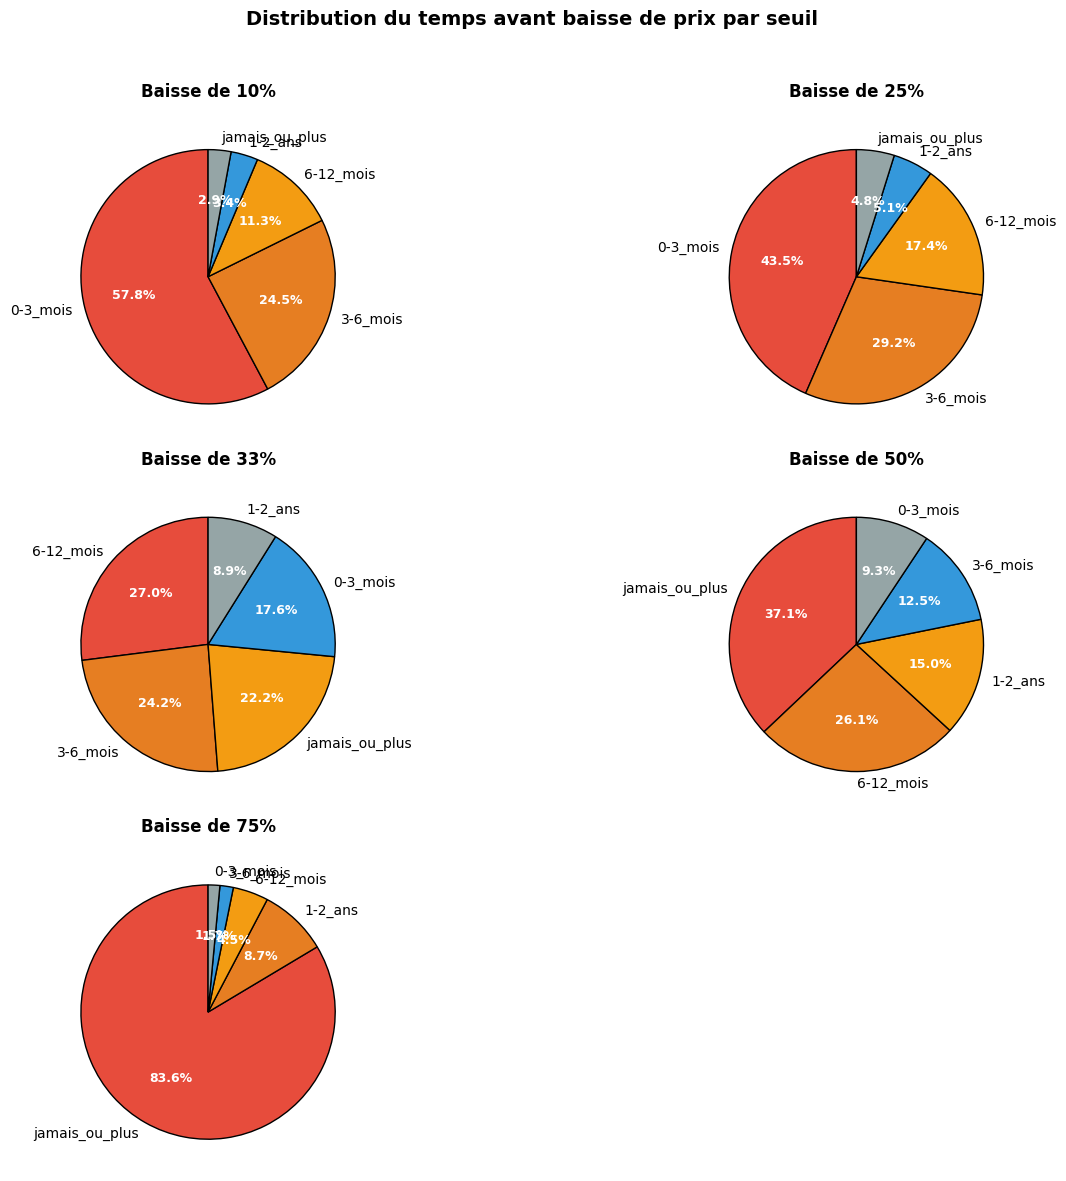

In [43]:
def filter_recent_games_without_discount(df: pd.DataFrame, months: int = 12) -> pd.DataFrame:
    """
    Enlève les jeux récents (< months mois) qui n'ont pas encore eu de baisse
    
    Args:
        df: DataFrame avec colonnes 'release_date' et 'days_to_25_percent_discount'
        months: Nombre de mois pour définir "récent" (défaut: 12)
    
    Returns:
        DataFrame filtré
    """
    from datetime import datetime, timedelta
    
    df_copy = df.copy()
    
    # Convertir release_date
    df_copy['release_date'] = pd.to_datetime(df_copy['release_date'])
    
    # Date de référence
    cutoff_date = datetime.now() - timedelta(days=months * 30)
    
    # Filtrer
    df_filtered = df_copy[
        (df_copy['days_to_25_percent_discount'].notna()) |  # A eu une baisse
        (df_copy['release_date'] < cutoff_date)             # OU ancien
    ]
    
    # Stats
    removed = len(df) - len(df_filtered)
    print(f"📊 Filtrage des jeux récents sans baisse:")
    print(f"   Jeux avant: {len(df)}")
    print(f"   Jeux après: {len(df_filtered)}")
    print(f"   Supprimés: {removed} ({removed/len(df)*100:.1f}%)")
    
    return df_filtered

def pie_charts_discount_categories_by_threshold(df: pd.DataFrame, fig):
    thresholds = [10, 25,33, 50, 75]
    threshold_columns = [
        'days_to_10_percent_discount',
        'days_to_25_percent_discount',
        'days_to_33_percent_discount',
        'days_to_50_percent_discount',
        'days_to_75_percent_discount'
    ]
    
    # Créer une grille 2x2
    for idx, (threshold, col) in enumerate(zip(thresholds, threshold_columns)):
        ax = plt.subplot(3, 2, idx + 1)
        
        # Créer les catégories pour ce seuil
        df_temp = df.copy()
        df_temp['category'] = pd.cut(
            df_temp[col],
            bins=[0, 90, 180, 365, 730, float('inf')],
            labels=['0-3_mois', '3-6_mois', '6-12_mois', '1-2_ans', 'jamais_ou_plus']
        )
        
        # Les NaN (jamais de baisse) → 'jamais_ou_plus'
        df_temp.loc[df_temp[col].isna(), 'category'] = 'jamais_ou_plus'
        
        # Compter les occurrences
        category_counts = df_temp['category'].value_counts()
        
        # Créer le pie chart
        colors = ['#e74c3c', '#e67e22', '#f39c12', '#3498db', '#95a5a6']
        
        wedges, texts, autotexts = ax.pie(
            category_counts.values,
            labels=category_counts.index,
            autopct='%1.1f%%',
            startangle=90,
            colors=colors,
            wedgeprops={'edgecolor': 'black', 'linewidth': 1}
        )
        
        # Style du texte
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
            autotext.set_fontsize(9)
        
        ax.set_aspect('equal')
        ax.set_title(f'Baisse de {threshold}%', pad=15, fontweight='bold')
    
    fig.suptitle('Distribution du temps avant baisse de prix par seuil', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])

# Utilisation
fig = plt.figure(figsize=(14, 12))

# Enlever les jeux récents du dataframe qui n'on pas encore eu de baisse < 1 an
df_filtered = filter_recent_games_without_discount(df)
pie_charts_discount_categories_by_threshold(df_filtered, fig)
plt.show()